In [1]:
# Importing necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import Imputer
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

In [2]:
#Creating a SparkSession
spark = SparkSession.builder \
    .appName("TrafficVolumeAnalysis") \
    .getOrCreate()

24/04/01 20:14:11 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
#Loading the dataset into a PySpark DataFrame
file_path = "file:///home/hduser/Desktop/SEM2_CA1/da_sem2_ca1_rep/dataset.csv"
df = spark.read.csv(file_path, header=True)

In [4]:
# Displaying schema
df.printSchema()

root
 |-- STATISTIC: string (nullable = true)
 |-- Statistic Label: string (nullable = true)
 |-- TLIST(A1): string (nullable = true)
 |-- Year: string (nullable = true)
 |-- C02875V03459: string (nullable = true)
 |-- Type of Vehicle: string (nullable = true)
 |-- UNIT: string (nullable = true)
 |-- VALUE: string (nullable = true)



In [5]:
# Displaying first few rows
df.show(5)

+---------+---------------+---------+----+------------+--------------------+------+-------+
|STATISTIC|Statistic Label|TLIST(A1)|Year|C02875V03459|     Type of Vehicle|  UNIT|  VALUE|
+---------+---------------+---------+----+------------+--------------------+------+-------+
|  THA10C1| Traffic Volume|     2000|2000|           -|   All vehicle types|Number|1666744|
|  THA10C1| Traffic Volume|     2000|2000|          10|        Private cars|Number|1314059|
|  THA10C1| Traffic Volume|     2000|2000|          20|      Goods vehicles|Number| 199259|
|  THA10C1| Traffic Volume|     2000|2000|          30|        Motor cycles|Number|  28489|
|  THA10C1| Traffic Volume|     2000|2000|          40|Tractors & Machinery|Number|  74211|
+---------+---------------+---------+----+------------+--------------------+------+-------+
only showing top 5 rows



In [6]:
# Summary statistics
df.describe().show()

24/04/01 20:14:17 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+---------+--------------------+-----------------+-----------------+------------------+--------------------+----------+-----------------+
|summary|STATISTIC|     Statistic Label|        TLIST(A1)|             Year|      C02875V03459|     Type of Vehicle|      UNIT|            VALUE|
+-------+---------+--------------------+-----------------+-----------------+------------------+--------------------+----------+-----------------+
|  count|      621|                 621|              621|              621|               621|                 621|       621|              621|
|   mean|     null|                null|           2011.0|           2011.0|              45.0|                null|      null|187615.0499194847|
| stddev|     null|                null|6.638596820257663|6.638596820257663|22.933661135264696|                null|      null|566037.9054208661|
|    min|  THA10C1|Average Kilometre...|             2000|             2000|                 -|   All vehicle types|Kilometr

In [7]:
# Dropping columns 
columns_to_drop = ['STATISTICS', 'TLIST(A1)', 'C02875V03459', 'UNIT']
df = df.drop(*columns_to_drop)

In [8]:
# Displaying first few rows
df.show(5)

+---------+---------------+----+--------------------+-------+
|STATISTIC|Statistic Label|Year|     Type of Vehicle|  VALUE|
+---------+---------------+----+--------------------+-------+
|  THA10C1| Traffic Volume|2000|   All vehicle types|1666744|
|  THA10C1| Traffic Volume|2000|        Private cars|1314059|
|  THA10C1| Traffic Volume|2000|      Goods vehicles| 199259|
|  THA10C1| Traffic Volume|2000|        Motor cycles|  28489|
|  THA10C1| Traffic Volume|2000|Tractors & Machinery|  74211|
+---------+---------------+----+--------------------+-------+
only showing top 5 rows



In [9]:
# Summary statistics
df.describe().show()

+-------+---------+--------------------+-----------------+--------------------+-----------------+
|summary|STATISTIC|     Statistic Label|             Year|     Type of Vehicle|            VALUE|
+-------+---------+--------------------+-----------------+--------------------+-----------------+
|  count|      621|                 621|              621|                 621|              621|
|   mean|     null|                null|           2011.0|                null|187615.0499194847|
| stddev|     null|                null|6.638596820257663|                null|566037.9054208661|
|    min|  THA10C1|Average Kilometre...|             2000|   All vehicle types|             1006|
|    max|  THA10C3|      Traffic Volume|             2022|Tractors & Machinery|              970|
+-------+---------+--------------------+-----------------+--------------------+-----------------+



In [10]:
#Filtering thr rows as required
df = df.filter(df['Statistic Label'] == "Traffic Volume")

In [11]:
df.show()

+---------+---------------+----+--------------------+-------+
|STATISTIC|Statistic Label|Year|     Type of Vehicle|  VALUE|
+---------+---------------+----+--------------------+-------+
|  THA10C1| Traffic Volume|2000|   All vehicle types|1666744|
|  THA10C1| Traffic Volume|2000|        Private cars|1314059|
|  THA10C1| Traffic Volume|2000|      Goods vehicles| 199259|
|  THA10C1| Traffic Volume|2000|        Motor cycles|  28489|
|  THA10C1| Traffic Volume|2000|Tractors & Machinery|  74211|
|  THA10C1| Traffic Volume|2000|          Small PSVs|  13983|
|  THA10C1| Traffic Volume|2000|          Large PSVs|   6726|
|  THA10C1| Traffic Volume|2000|     Exempt vehicles|  12448|
|  THA10C1| Traffic Volume|2000|      Other vehicles|  17569|
|  THA10C1| Traffic Volume|2001|   All vehicle types|1748599|
|  THA10C1| Traffic Volume|2001|        Private cars|1372672|
|  THA10C1| Traffic Volume|2001|      Goods vehicles| 214767|
|  THA10C1| Traffic Volume|2001|        Motor cycles|  31589|
|  THA10

In [12]:
# Extracting values for plotting
years = df.select("Year").rdd.flatMap(lambda x: x).collect()
traffic_volumes = df.select("VALUE").rdd.flatMap(lambda x: x).collect()

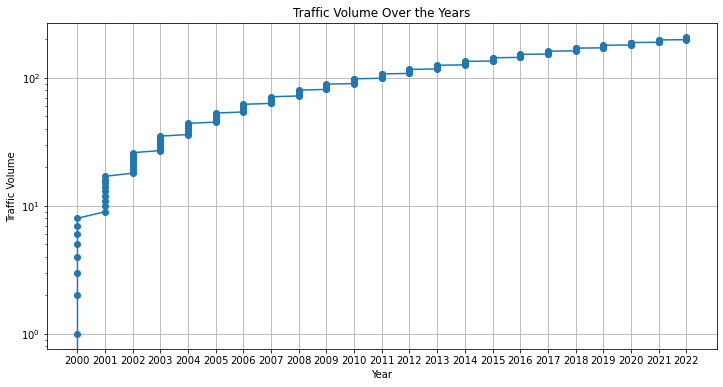

In [13]:
# Plotting traffic volume over the years with logarithmic scale on Y-axis
plt.figure(figsize=(12, 6))
plt.plot(years, traffic_volumes, marker='o', linestyle='-')
plt.yscale('log')  # Set logarithmic scale for Y-axis
plt.title("Traffic Volume Over the Years")
plt.xlabel("Year")
plt.ylabel("Traffic Volume")
plt.grid(True)
plt.show()

In [21]:
df = df.withColumn("VALUE", col("VALUE").cast("double"))

In [22]:
# Defining and trainning the model Random Forest Regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="VALUE")  # Update labelCol to the correct column name
model = rf.fit(training_data)

IllegalArgumentException: requirement failed: Column VALUE must be of type numeric but was actually of type string.